# 국민체육진흥원의 체력100에 따른 개인 맞춤형 건강등급 예측 알고리즘
#### by F-T AIsland from Tech-IT AI school 9th

##### 문화빅데이터 플랫폼에 저장된 체력측정 및 운동처방 종합 데이터를 사용함
##### 데이터 기간 : 2013.03 ~ 2022.12
##### 데이터 출처 : https://www.bigdata-culture.kr/bigdata/user/data_market/detail.do?id=b3924850-aa65-11ec-8ee4-95f65f846b27


In [1]:
# 모듈 임포트

import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 향후 버전 업에 대한 경고 메시지 출력 안하기 
import warnings

warnings.filterwarnings(action='ignore') 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from scipy import stats
from statsmodels.formula.api import ols, glm

from prophet import Prophet

from sklearn.tree import DecisionTreeClassifier # 의사결정나무 알고리즘
from sklearn.ensemble import RandomForestClassifier # 랜덤포레스트 알고리즘
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀분석 알고리즘
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification
from joblib import dump, load

### 정제된 데이터 불러오기

In [3]:
# 데이터 불러오기
child = pd.read_csv(r"./data_child_final.csv", parse_dates=['MESURE_DE'])
teen = pd.read_csv(r"./data_teen_final.csv", parse_dates=['MESURE_DE'])
adult = pd.read_csv(r"./data_adult_final.csv", parse_dates=['MESURE_DE'])
elder = pd.read_csv(r"./data_elder_final.csv", parse_dates=['MESURE_DE'])

# 'Unnamed: 0' 제거하기
child.drop(['Unnamed: 0'], axis=1, inplace=True)
teen.drop(['Unnamed: 0'], axis=1, inplace=True)
adult.drop(['Unnamed: 0'], axis=1, inplace=True)
elder.drop(['Unnamed: 0'], axis=1, inplace=True)

### 1. 데이터 학습시키기


In [4]:
# 학습, 검정용 데이터 분리하기
# 유소년(child) 데이터
# X,Y분할하기
child_y = child['CRTFC_FLAG_NM']
child_x = child.drop(['CNTER_NM', 'AGRDE_FLAG_NM','MESURE_DE', 'CRTFC_FLAG_NM','MVM_PRSCRPTN_CN'], axis=1, inplace=False)
child_x_train, child_x_test, child_y_train, child_y_test = train_test_split(child_x, child_y, test_size=0.2, random_state=0)  # 훈련용, 테스트용 분할

# 청소년(teen) 데이터
# X,Y분할하기
teen_y = teen['CRTFC_FLAG_NM']
teen_x = teen.drop(['CNTER_NM', 'AGRDE_FLAG_NM','MESURE_DE', 'CRTFC_FLAG_NM','MVM_PRSCRPTN_CN'], axis=1, inplace=False)
teen_x_train, teen_x_test, teen_y_train, teen_y_test = train_test_split(teen_x, teen_y, test_size=0.2, random_state=0)  # 훈련용, 테스트용 분할

# 성인(adult) 데이터
# X,Y분할하기
adult_y = adult['CRTFC_FLAG_NM']
adult_x = adult.drop(['CNTER_NM', 'AGRDE_FLAG_NM','MESURE_DE', 'CRTFC_FLAG_NM','MVM_PRSCRPTN_CN'], axis=1, inplace=False)
adult_x_train, adult_x_test, adult_y_train, adult_y_test = train_test_split(adult_x, adult_y, test_size=0.2, random_state=0)  # 훈련용, 테스트용 분할

# 노인(elder) 데이터
elder_y = elder['CRTFC_FLAG_NM']
elder_x = elder.drop(['CNTER_NM', 'AGRDE_FLAG_NM','MESURE_DE', 'CRTFC_FLAG_NM','MVM_PRSCRPTN_CN'], axis=1, inplace=False)
elder_x_train, elder_x_test, elder_y_train, elder_y_test = train_test_split(elder_x, elder_y, test_size=0.2, random_state=0)  # 훈련용, 테스트용 분할

In [5]:
adult.head()

,CNTER_NM,AGRDE_FLAG_NM,MESURE_AGE_CO,CRTFC_FLAG_NM,MESURE_DE,SEXDSTN_FLAG_CD,MESURE_IEM_001_VALUE,MESURE_IEM_002_VALUE,MESURE_IEM_012_VALUE,MESURE_IEM_018_VALUE,MESURE_IEM_019_VALUE,MESURE_IEM_020_VALUE,MESURE_IEM_021_VALUE,MESURE_IEM_022_VALUE,MVM_PRSCRPTN_CN
0,남양주,성인,32.0,3,2013-03-05,1,170.0,80.00,20.0,27.7,55.0,20.0,9.00,130.0,본운동:바벨 끌어당기기
1,원주,성인,44.0,4,2013-03-05,1,157.4,66.60,21.4,26.9,23.0,15.0,15.00,140.0,"본운동:넙다리 뒤쪽 스트레칭,상지 루틴 스트레칭,옆구리 스트레칭,하지 루틴 스트레칭..."
2,광산,성인,42.0,4,2013-03-05,1,161.9,76.40,23.1,29.1,16.0,4.0,14.63,133.0,"본운동:트레드밀에서 걷기,물병 옆으로 들어올리기,앉았다 일어서기,탄력밴드 어깨 가쪽..."
3,광산,성인,27.0,4,2013-03-05,0,179.2,98.30,11.4,30.6,44.0,40.0,11.20,151.0,"본운동:수영,서서 균형잡으며 몸통 회전하기,짝 운동"
4,원주,성인,55.0,4,2013-03-05,1,155.8,58.24,10.6,24.0,8.0,8.0,18.50,90.0,"본운동:넙다리 뒤쪽 스트레칭,목 스트레칭,옆구리 스트레칭,전신 루틴 스트레칭,실내 ..."


### sklearn 모델링

- 유소년 데이터 sklearn 선형회귀학습

In [6]:
# 선형회귀분석 : 모델 생성
child_lr = LinearRegression()

# 선형회귀분석 : 모델 훈련
child_lr.fit(child_x_train, child_y_train)

LinearRegression()

In [7]:
# 선형회귀분석 : 평가 데이터에 대한 예측 수행 -> 예측 결과 Y_predict 구하기
child_y_predict = child_lr.predict(child_x_test)

child_mse = mean_squared_error(child_y_test, child_y_predict)
child_rmse = np.sqrt(child_mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(child_mse, child_rmse))
print('R^2(Variance score) : {0:.3f}'.format(r2_score(child_y_test, child_y_predict)))

print('Y 절편 값: ',  np.round(child_lr.intercept_, 2))
print('회귀 계수 값: ', np.round(child_lr.coef_, 2))

coef = pd.Series(data=np.round(child_lr.coef_, 2), index=child_x.columns)
coef.sort_values(ascending=False)

MSE : 0.308, RMSE : 0.555
R^2(Variance score) : 0.391
Y 절편 값:  3.13
회귀 계수 값:  [ 0.08 -0.11  0.   -0.01 -0.02  0.03 -0.01 -0.  ]


MESURE_AGE_CO           0.08
MESURE_IEM_018_VALUE    0.03
MESURE_IEM_001_VALUE    0.00
MESURE_IEM_022_VALUE   -0.00
MESURE_IEM_002_VALUE   -0.01
MESURE_IEM_020_VALUE   -0.01
MESURE_IEM_012_VALUE   -0.02
SEXDSTN_FLAG_CD        -0.11
dtype: float64

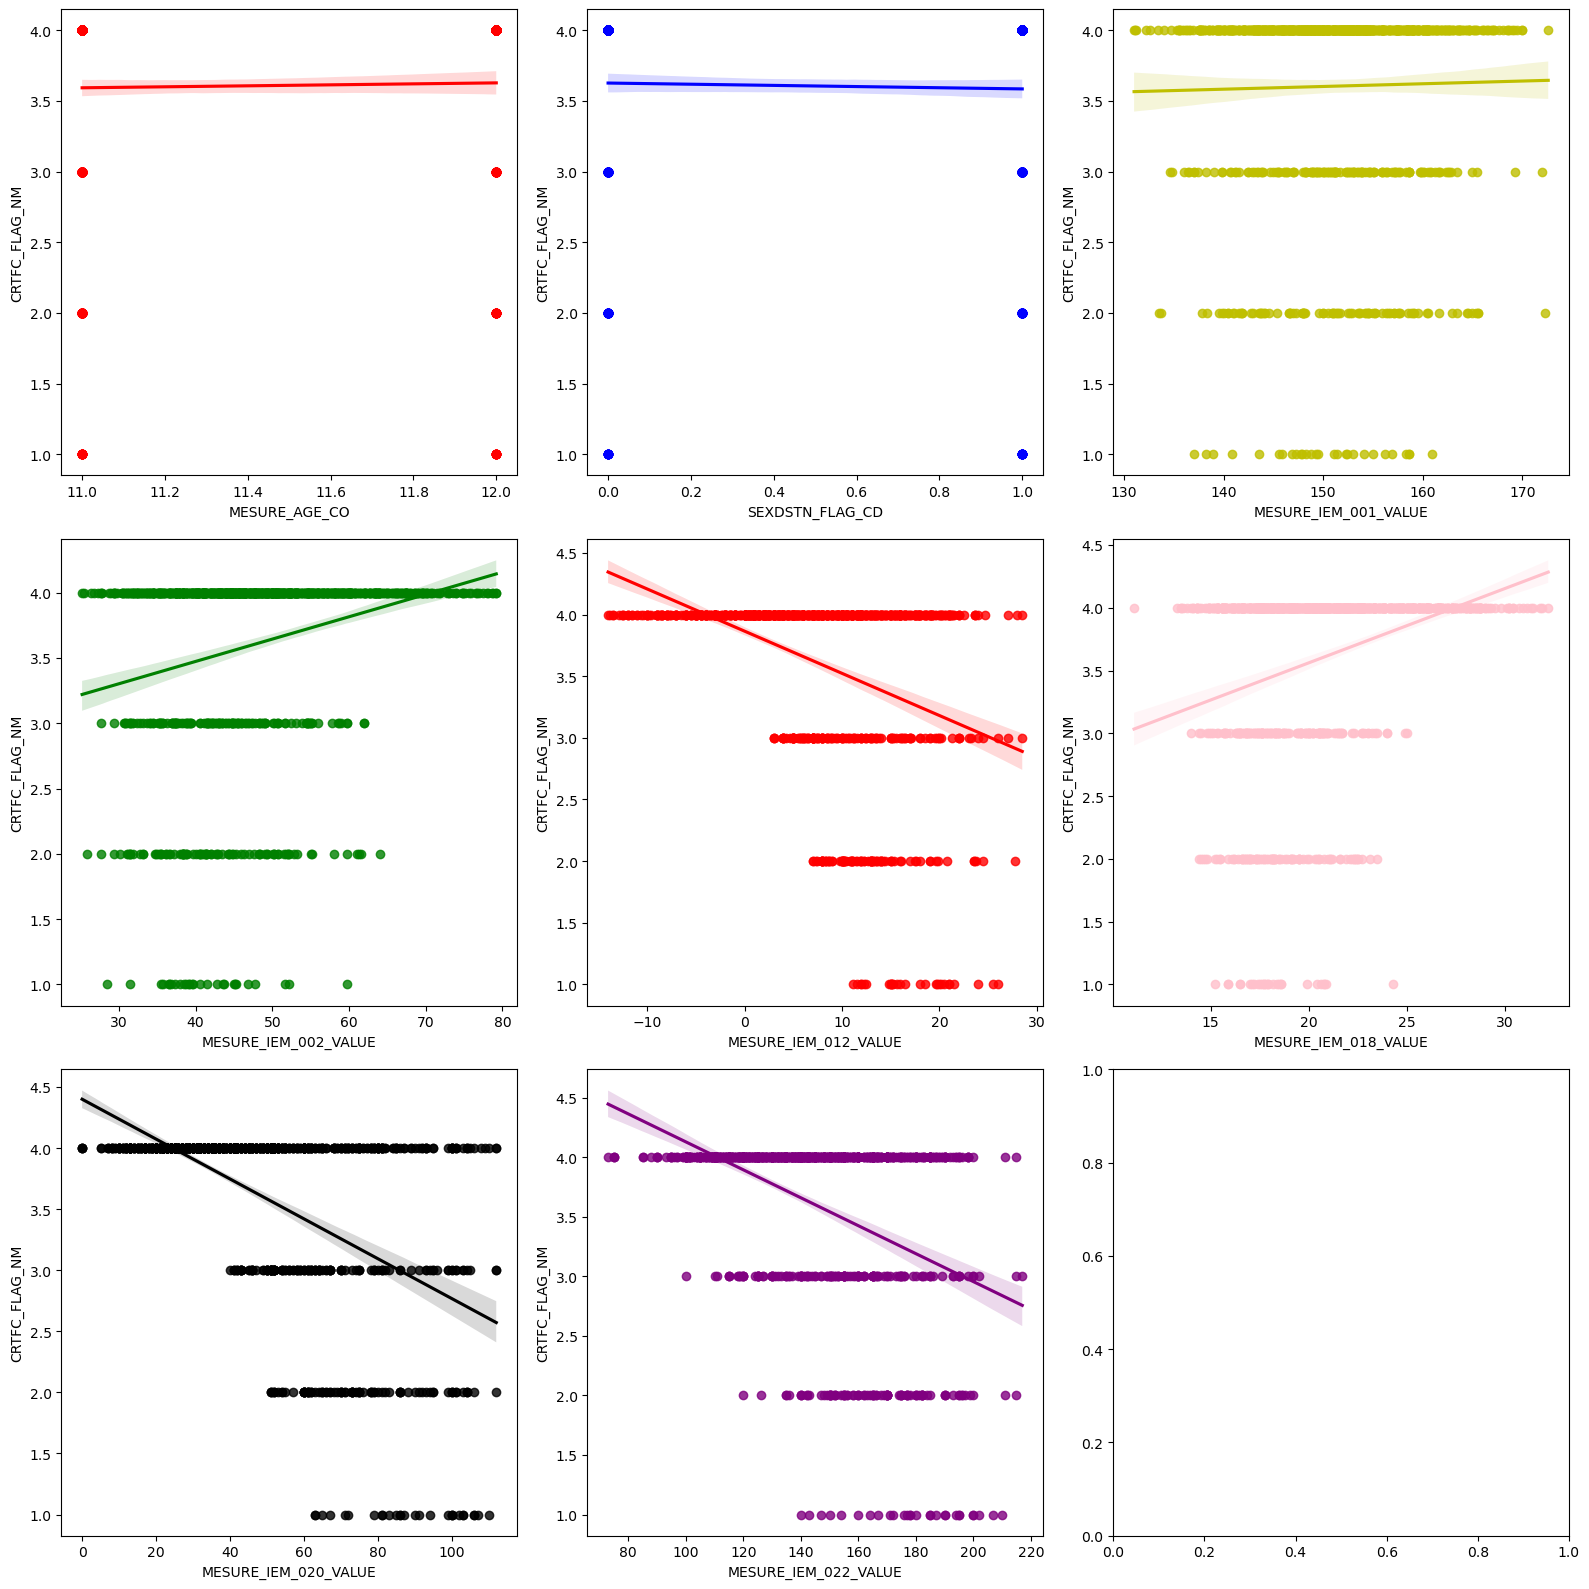

In [8]:
# 유소년 데이터에서 무작위로 1000개의 샘플 추출
child_sampled_data = child.sample(n=1000, random_state=42)  # 1000개의 샘플 추출, random_state는 재현성을 위한 시드값

# 선형회귀 그래프 그리기
fig, axs = plt.subplots(figsize=(16, 16), ncols=3, nrows=3)

x_features = ['MESURE_AGE_CO', 'SEXDSTN_FLAG_CD', 'MESURE_IEM_001_VALUE', 'MESURE_IEM_002_VALUE', 'MESURE_IEM_012_VALUE', 'MESURE_IEM_018_VALUE', 'MESURE_IEM_020_VALUE', 'MESURE_IEM_022_VALUE']
plot_color = ['r', 'b', 'y', 'g', 'r', 'pink', 'black','purple']

for i, feature in enumerate(x_features):
    row = int(i/3)
    col = i%3
    sns.regplot(x=feature, y='CRTFC_FLAG_NM', data=child_sampled_data, ax=axs[row][col], color=plot_color[i])

plt.tight_layout()
plt.show()

- 청소년 데이터 sklearn 학습

In [9]:
# 선형회귀분석 : 모델 생성
teen_lr = LinearRegression()

# 선형회귀분석 : 모델 훈련
teen_lr.fit(teen_x_train, teen_y_train)

LinearRegression()

In [10]:
# 선형회귀분석 : 평가 데이터에 대한 예측 수행 -> 예측 결과 Y_predict 구하기
teen_y_predict = teen_lr.predict(teen_x_test)

teen_mse = mean_squared_error(teen_y_test, teen_y_predict)
teen_rmse = np.sqrt(teen_mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(teen_mse, teen_rmse))
print('R^2(Variance score) : {0:.3f}'.format(r2_score(teen_y_test, teen_y_predict)))

print('Y 절편 값: ',  np.round(teen_lr.intercept_, 2))
print('회귀 계수 값: ', np.round(teen_lr.coef_, 2))

coef = pd.Series(data=np.round(teen_lr.coef_, 2), index=teen_x.columns)
coef.sort_values(ascending=False)

MSE : 0.422, RMSE : 0.649
R^2(Variance score) : 0.432
Y 절편 값:  2.68
회귀 계수 값:  [ 0.04 -0.24  0.01 -0.   -0.03  0.04 -0.02 -0.  ]


MESURE_AGE_CO           0.04
MESURE_IEM_018_VALUE    0.04
MESURE_IEM_001_VALUE    0.01
MESURE_IEM_002_VALUE   -0.00
MESURE_IEM_022_VALUE   -0.00
MESURE_IEM_020_VALUE   -0.02
MESURE_IEM_012_VALUE   -0.03
SEXDSTN_FLAG_CD        -0.24
dtype: float64

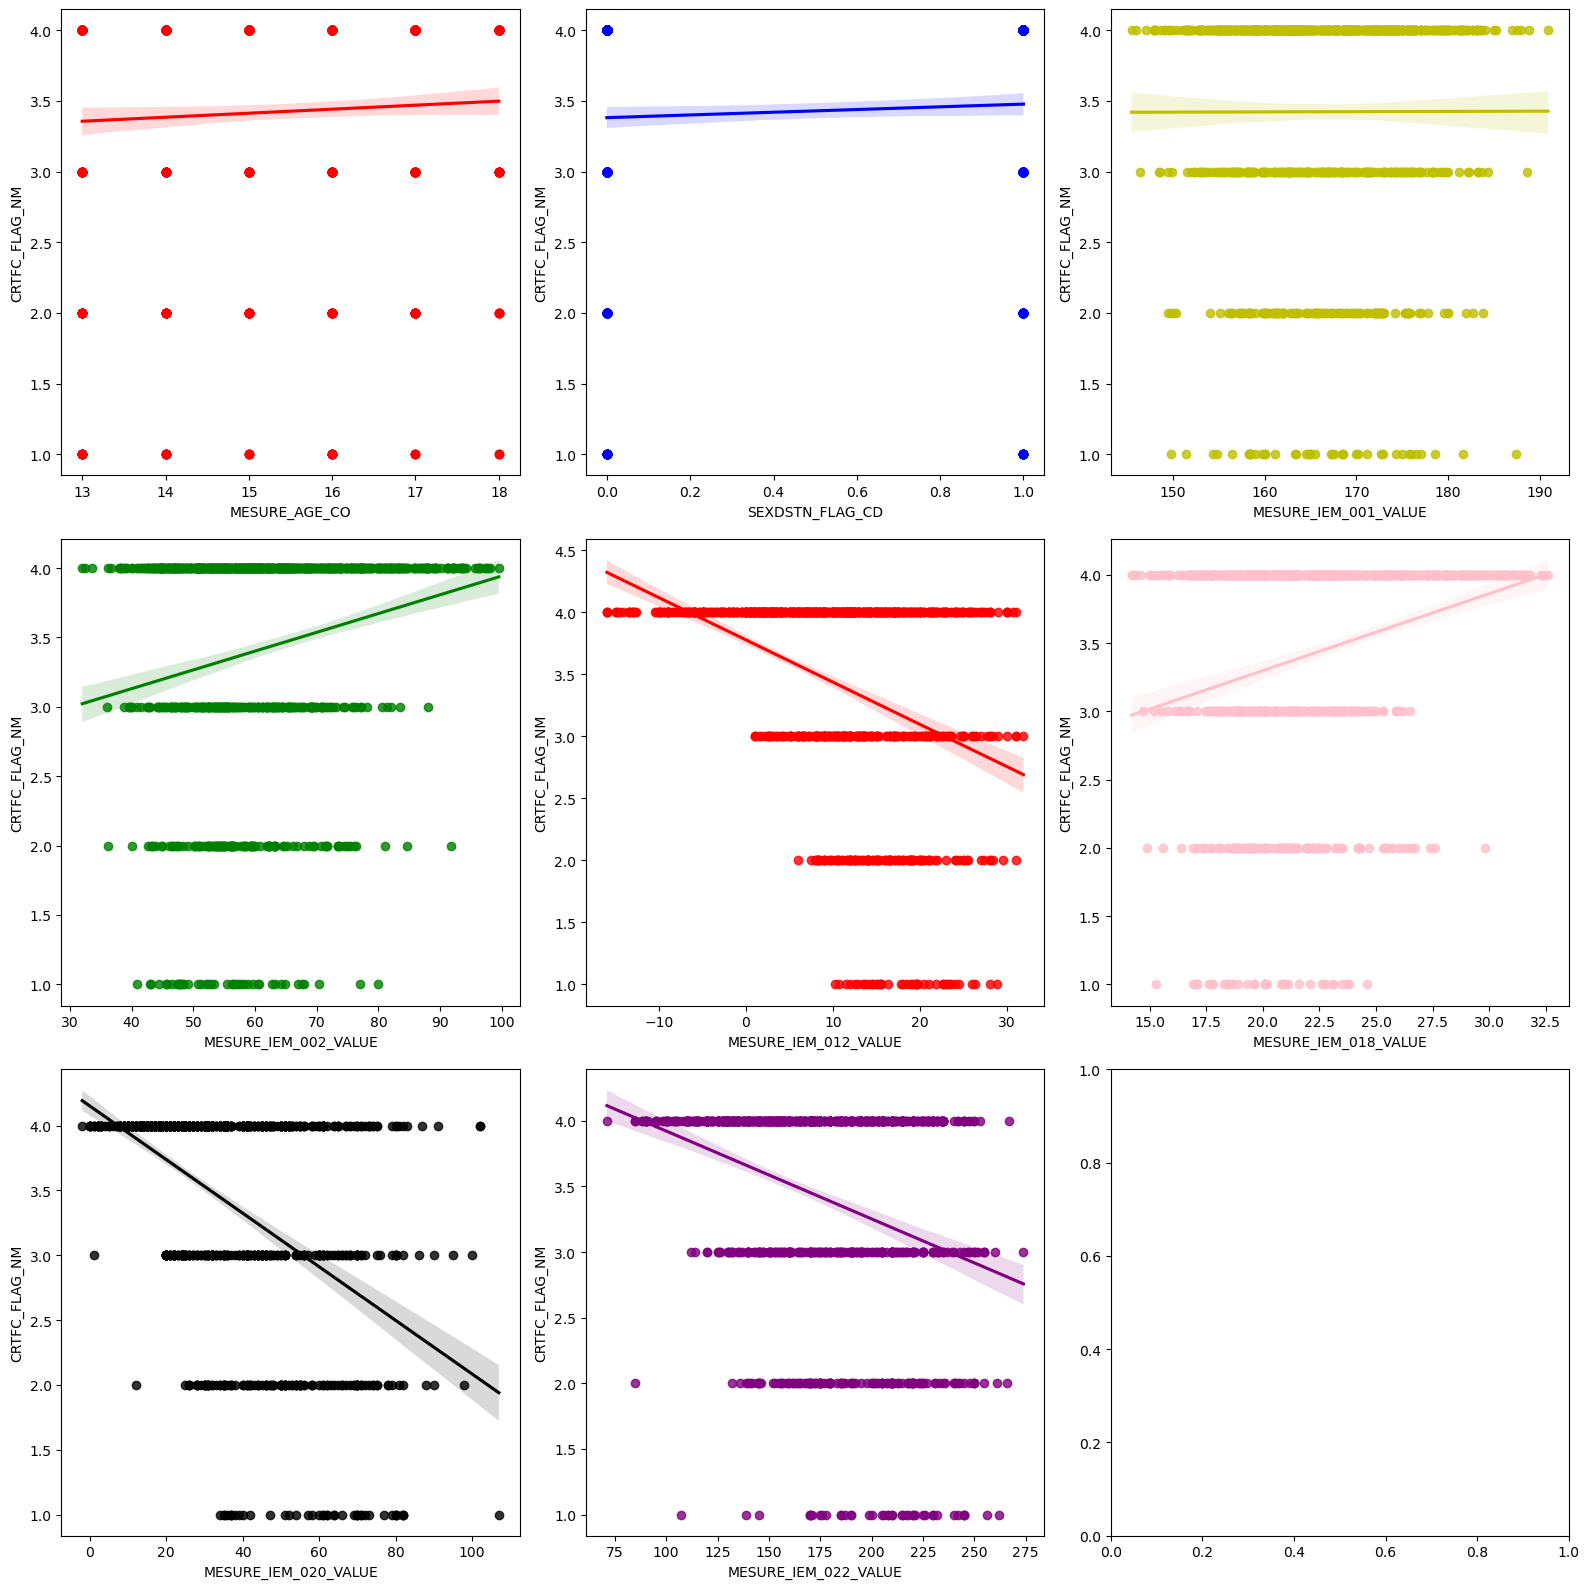

In [11]:
# 청소년 데이터에서 무작위로 1000개의 샘플 추출
teen_sampled_data = teen.sample(n=1000, random_state=42)  # 1000개의 샘플 추출, random_state는 재현성을 위한 시드값

# 선형회귀 그래프 그리기
fig, axs = plt.subplots(figsize=(16, 16), ncols=3, nrows=3)

x_features = ['MESURE_AGE_CO', 'SEXDSTN_FLAG_CD', 'MESURE_IEM_001_VALUE', 'MESURE_IEM_002_VALUE', 'MESURE_IEM_012_VALUE', 'MESURE_IEM_018_VALUE', 'MESURE_IEM_020_VALUE', 'MESURE_IEM_022_VALUE']
plot_color = ['r', 'b', 'y', 'g', 'r', 'pink', 'black','purple']

for i, feature in enumerate(x_features):
    row = int(i/3)
    col = i%3
    sns.regplot(x=feature, y='CRTFC_FLAG_NM', data=teen_sampled_data, ax=axs[row][col], color=plot_color[i])

plt.tight_layout()
plt.show()

- 성인 데이터 sklearn 학습

In [12]:
# 선형회귀분석 : 모델 생성
adult_lr = LinearRegression()

# 선형회귀분석 : 모델 훈련
adult_lr.fit(adult_x_train, adult_y_train)

LinearRegression()

In [13]:
# 선형회귀분석 : 평가 데이터에 대한 예측 수행 -> 예측 결과 Y_predict 구하기
adult_y_predict = adult_lr.predict(adult_x_test)

adult_mse = mean_squared_error(adult_y_test, adult_y_predict)
adult_rmse = np.sqrt(adult_mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(adult_mse, adult_rmse))
print('R^2(Variance score) : {0:.3f}'.format(r2_score(adult_y_test, adult_y_predict)))

print('Y 절편 값: ',  np.round(adult_lr.intercept_, 2))
print('회귀 계수 값: ', np.round(adult_lr.coef_, 2))

coef = pd.Series(data=np.round(adult_lr.coef_, 2), index=adult_x.columns)
coef.sort_values(ascending=False)

MSE : 0.414, RMSE : 0.643
R^2(Variance score) : 0.479
Y 절편 값:  0.35
회귀 계수 값:  [-0.02 -0.5   0.03 -0.03 -0.03  0.13 -0.02 -0.02  0.03 -0.  ]


MESURE_IEM_018_VALUE    0.13
MESURE_IEM_001_VALUE    0.03
MESURE_IEM_021_VALUE    0.03
MESURE_IEM_022_VALUE   -0.00
MESURE_AGE_CO          -0.02
MESURE_IEM_019_VALUE   -0.02
MESURE_IEM_020_VALUE   -0.02
MESURE_IEM_002_VALUE   -0.03
MESURE_IEM_012_VALUE   -0.03
SEXDSTN_FLAG_CD        -0.50
dtype: float64

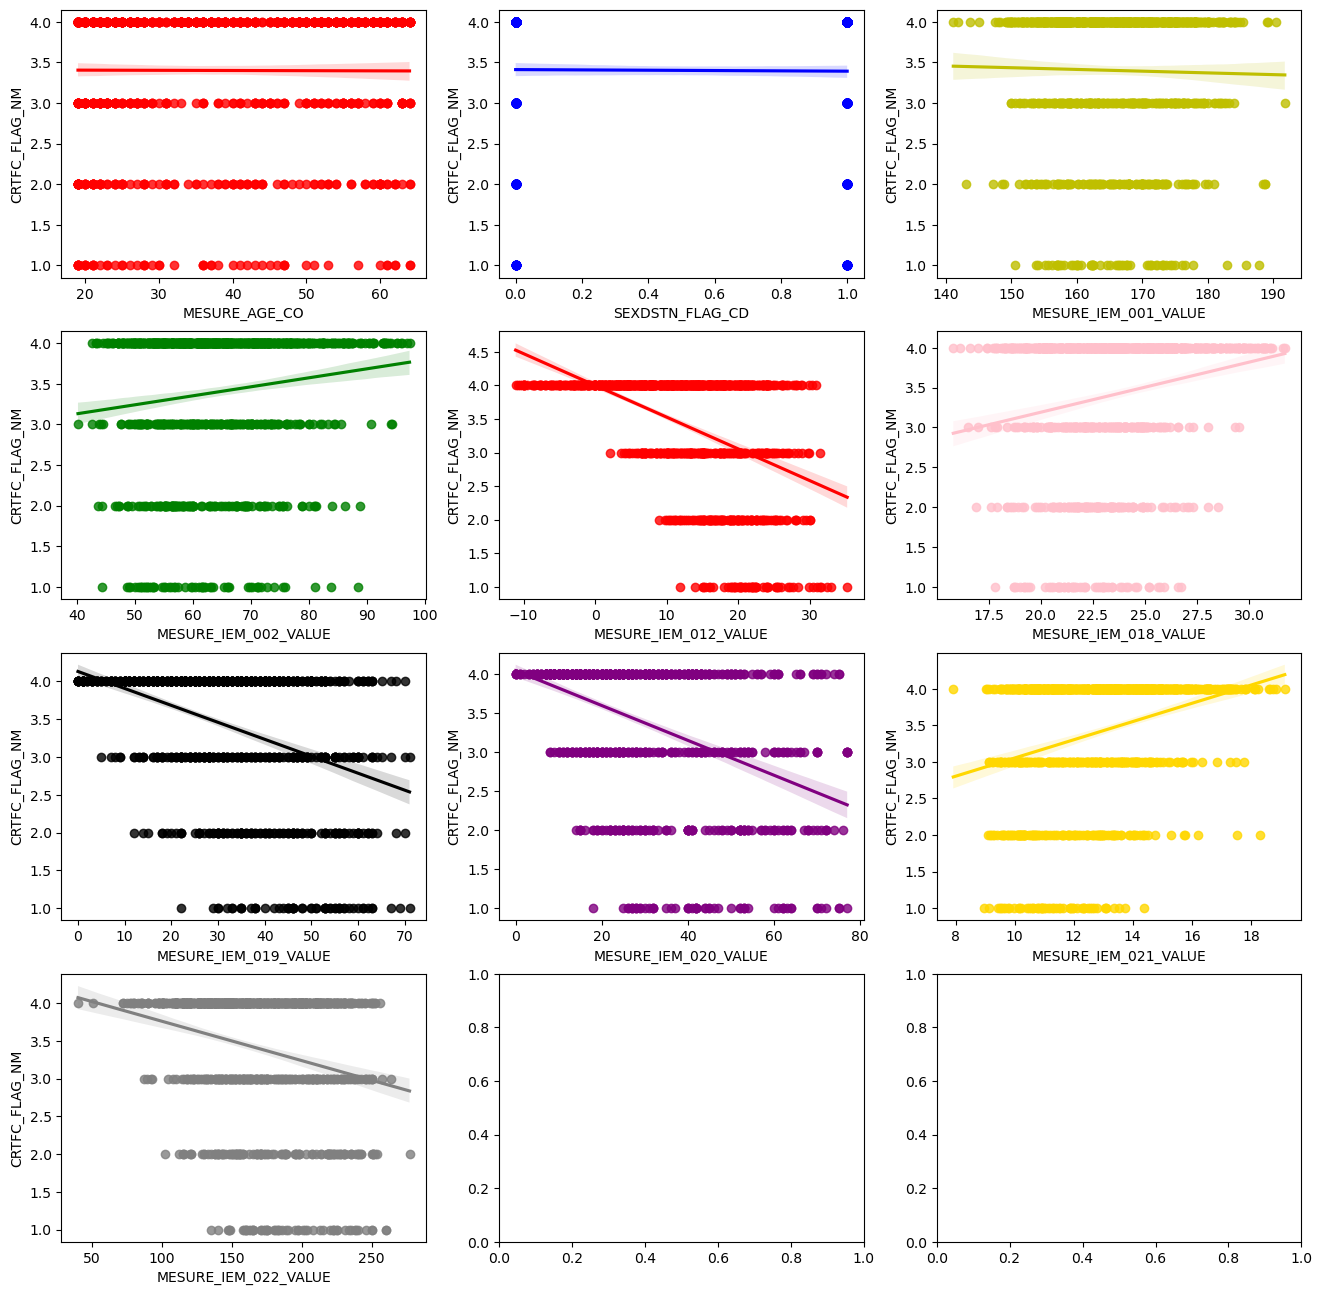

In [14]:
# 성인 데이터에서 무작위로 1000개의 샘플 추출
adult_sampled_data = adult.sample(n=1000, random_state=42)  # 1000개의 샘플 추출, random_state는 재현성을 위한 시드값

# 선형회귀 그래프 그리기
fig, axs = plt.subplots(figsize=(16, 16), ncols=3, nrows=4)

x_features = ['MESURE_AGE_CO', 'SEXDSTN_FLAG_CD', 'MESURE_IEM_001_VALUE', 'MESURE_IEM_002_VALUE', 'MESURE_IEM_012_VALUE', 'MESURE_IEM_018_VALUE','MESURE_IEM_019_VALUE', 'MESURE_IEM_020_VALUE', 'MESURE_IEM_021_VALUE', 'MESURE_IEM_022_VALUE']
plot_color = ['r', 'b', 'y', 'g', 'r', 'pink', 'black','purple', 'gold', 'gray']

for i, feature in enumerate(x_features):
      row = int(i/3)
      col = i%3
      sns.regplot(x=feature, y='CRTFC_FLAG_NM', data=adult_sampled_data, ax=axs[row][col], color=plot_color[i])

- 노인데이터 sklearn학습

In [15]:
# 선형회귀분석 : 모델 생성
elder_lr = LinearRegression()

# 선형회귀분석 : 모델 훈련
elder_lr.fit(elder_x_train, elder_y_train)

LinearRegression()

In [16]:
# 선형회귀분석 : 평가 데이터에 대한 예측 수행 -> 예측 결과 Y_predict 구하기
elder_y_predict = elder_lr.predict(elder_x_test)

elder_mse = mean_squared_error(elder_y_test, elder_y_predict)
elder_rmse = np.sqrt(elder_mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(elder_mse, elder_rmse))
print('R^2(Variance score) : {0:.3f}'.format(r2_score(elder_y_test, elder_y_predict)))

print('Y 절편 값: ',  np.round(elder_lr.intercept_, 2))
print('회귀 계수 값: ', np.round(elder_lr.coef_, 2))

coef = pd.Series(data=np.round(elder_lr.coef_, 2), index=elder_x.columns)
coef.sort_values(ascending=False)

MSE : 0.411, RMSE : 0.641
R^2(Variance score) : 0.546
Y 절편 값:  8.54
회귀 계수 값:  [-0.   -0.06  0.21 -0.    0.   -0.05  0.03 -0.04 -0.01  0.04]


SEXDSTN_FLAG_CD         0.21
MESURE_IEM_027_VALUE    0.04
MESURE_IEM_018_VALUE    0.03
Unnamed: 0.1           -0.00
MESURE_IEM_001_VALUE   -0.00
MESURE_IEM_002_VALUE    0.00
MESURE_IEM_025_VALUE   -0.01
MESURE_IEM_023_VALUE   -0.04
MESURE_IEM_012_VALUE   -0.05
MESURE_AGE_CO          -0.06
dtype: float64

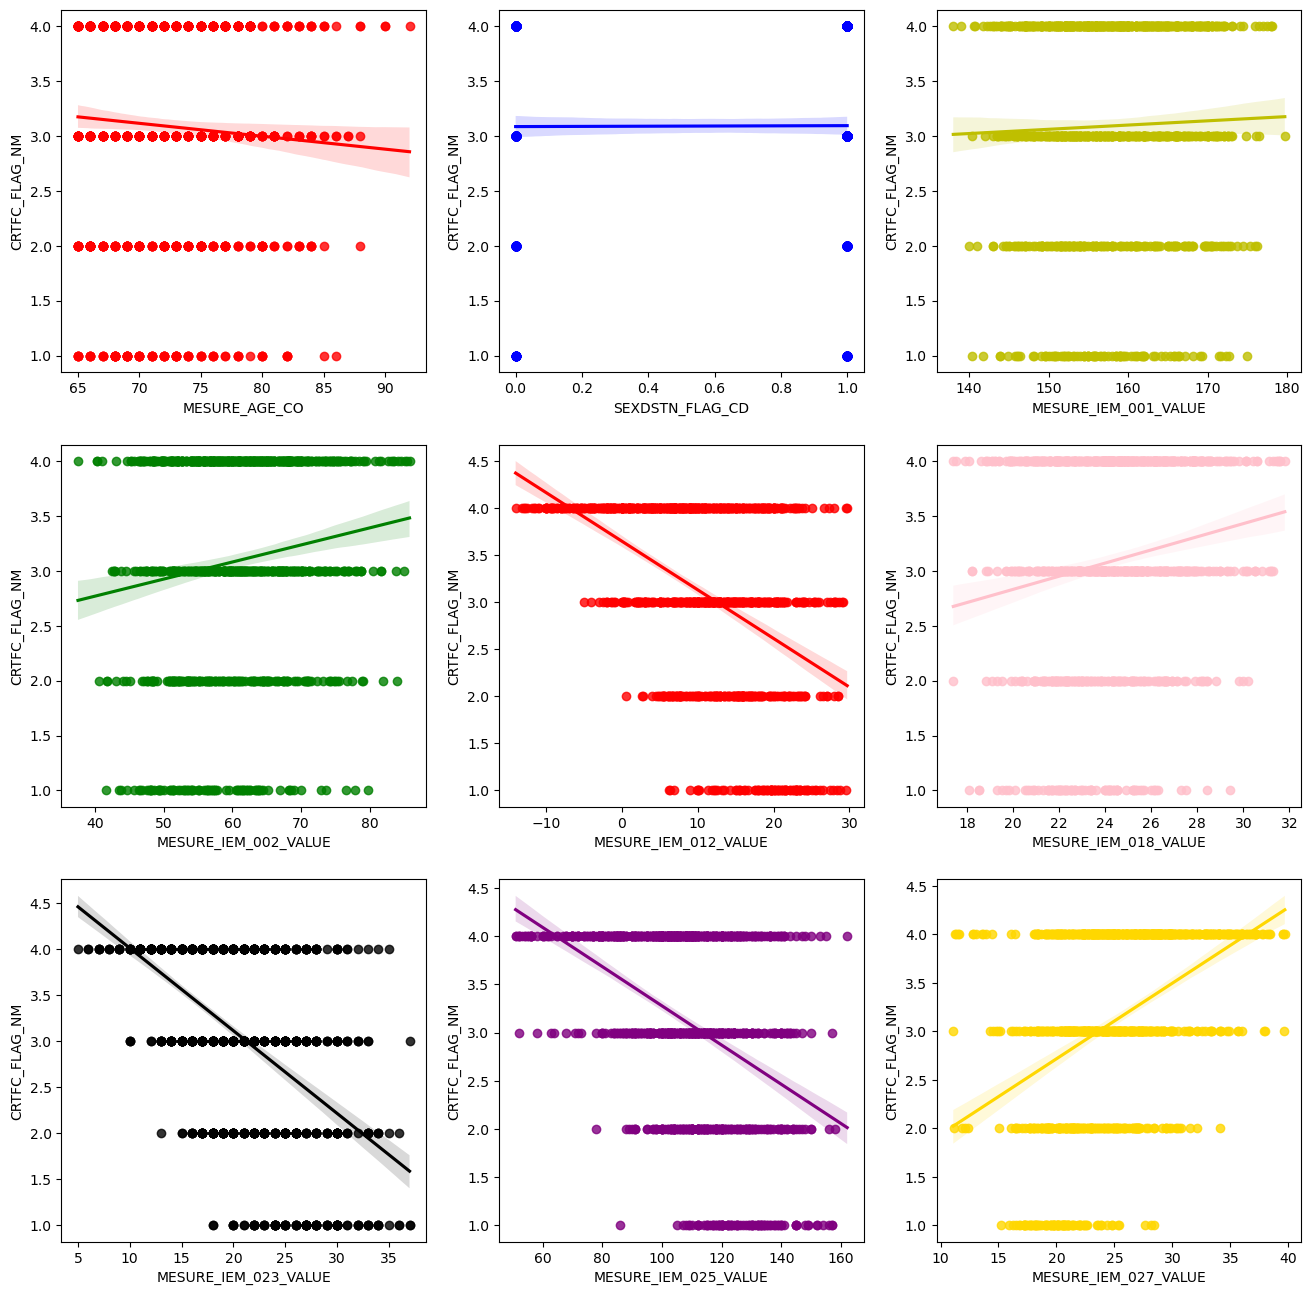

In [17]:
# 선형회귀 그래프 그리기
# 노인 데이터에서 무작위로 1000개의 샘플 추출
elder_sampled_data = elder.sample(n=1000, random_state=42)  # 1000개의 샘플 추출, random_state는 재현성을 위한 시드값


fig, axs = plt.subplots(figsize=(16, 16), ncols=3, nrows=3)

x_features = ['MESURE_AGE_CO', 'SEXDSTN_FLAG_CD', 'MESURE_IEM_001_VALUE', 'MESURE_IEM_002_VALUE', 'MESURE_IEM_012_VALUE', 'MESURE_IEM_018_VALUE', 'MESURE_IEM_023_VALUE', 'MESURE_IEM_025_VALUE', 'MESURE_IEM_027_VALUE' ]
plot_color = ['r', 'b', 'y', 'g', 'r', 'pink', 'black','purple', 'gold' ]

for i, feature in enumerate(x_features):
      row = int(i/3)
      col = i%3
      sns.regplot(x=feature, y='CRTFC_FLAG_NM', data=elder_sampled_data, ax=axs[row][col], color=plot_color[i])

## ols model 학습


In [18]:
# 유소년 데이터 학습
Rformula = 'CRTFC_FLAG_NM ~ MESURE_AGE_CO + SEXDSTN_FLAG_CD + MESURE_IEM_001_VALUE + \
            MESURE_IEM_002_VALUE + MESURE_IEM_012_VALUE + MESURE_IEM_018_VALUE + \
            MESURE_IEM_020_VALUE + MESURE_IEM_022_VALUE'

child_scipy_lr = ols(Rformula, data = child).fit()
child_scipy_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CRTFC_FLAG_NM   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     2477.
Date:                Sun, 19 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:21:16   Log-Likelihood:                -25919.
No. Observations:               31378   AIC:                         5.186e+04
Df Residuals:                   31369   BIC:                         5.193e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.0792      0.328      9.377      0.000       2.436       3.723
MESURE_AGE_CO            0.0804      0.007     11.056      0.000       0.066       0.095
SEXDSTN_FLAG_CD         -0.1085      0.008    -13.933      0.000      -0.124      -0.093
MESURE_IEM_001_VALUE     0.0044      0.002      2.050      0.040       0.000       0.009
MESURE_IEM_002_VALUE    -0.0063      0.003     -1.854      0.064      -0.013       0.000
MESURE_IEM_012_VALUE    -0.0231      0.000    -54.492      0.000      -0.024      -0.022
MESURE_IEM_018_VALUE     0.0292      0.008      3.687      0.000       0.014       0.045
MESURE_IEM_020_VALUE    -0.0123      0.000    -78.681      0.000      -0.013      -0.012
MESURE_IEM_022_VALUE    -0.0034      0.000    -21.424      0.000      -0.004      -0.003
==============================================================================
Omnibus:                     4081.241   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6761.092
Skew:                          -0.894   Prob(JB):                         0.00
Kurtosis:                       4.406   Cond. No.                     2.35e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
# 청소년 데이터 학습
Rformula = 'CRTFC_FLAG_NM ~ MESURE_AGE_CO + SEXDSTN_FLAG_CD + MESURE_IEM_001_VALUE + \
            MESURE_IEM_002_VALUE + MESURE_IEM_012_VALUE + MESURE_IEM_018_VALUE + \
            MESURE_IEM_020_VALUE + MESURE_IEM_022_VALUE'

teen_scipy_lr = ols(Rformula, data = teen).fit()
teen_scipy_lr.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CRTFC_FLAG_NM   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                 1.883e+04
Date:                Sun, 19 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:21:16   Log-Likelihood:            -1.9830e+05
No. Observations:              201459   AIC:                         3.966e+05
Df Residuals:                  201450   BIC:                         3.967e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.5351      0.170     14.945      0.000       2.203       2.868
MESURE_AGE_CO            0.0409      0.001     40.879      0.000       0.039       0.043
SEXDSTN_FLAG_CD         -0.2334      0.005    -48.640      0.000      -0.243      -0.224
MESURE_IEM_001_VALUE     0.0090      0.001      8.728      0.000       0.007       0.011
MESURE_IEM_002_VALUE    -0.0056      0.001     -4.130      0.000      -0.008      -0.003
MESURE_IEM_012_VALUE    -0.0315      0.000   -195.304      0.000      -0.032      -0.031
MESURE_IEM_018_VALUE     0.0412      0.004     10.826      0.000       0.034       0.049
MESURE_IEM_020_VALUE    -0.0181   9.25e-05   -196.261      0.000      -0.018      -0.018
MESURE_IEM_022_VALUE    -0.0041   6.02e-05    -68.505      0.000      -0.004      -0.004
==============================================================================
Omnibus:                     6259.126   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7042.696
Skew:                          -0.418   Prob(JB):                         0.00
Kurtosis:                       3.374   Cond. No.                     2.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
print("R-squared:", teen_scipy_lr.rsquared)
print("Adjusted R-squared:", teen_scipy_lr.rsquared_adj)
print("F-statistic:", teen_scipy_lr.fvalue)
print("p-value:", teen_scipy_lr.f_pvalue)

R-squared: 0.42783908623708056
Adjusted R-squared: 0.4278163645328855
F-statistic: 18829.533320361694
p-value: 0.0


In [21]:
# 성인 데이터 학습
Rformula = 'CRTFC_FLAG_NM ~ MESURE_AGE_CO + SEXDSTN_FLAG_CD + MESURE_IEM_001_VALUE + \
            MESURE_IEM_002_VALUE + MESURE_IEM_012_VALUE + MESURE_IEM_018_VALUE + \
            MESURE_IEM_019_VALUE + MESURE_IEM_020_VALUE + MESURE_IEM_021_VALUE + MESURE_IEM_022_VALUE'

adult_scipy_lr = ols(Rformula, data = adult).fit()
adult_scipy_lr.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CRTFC_FLAG_NM   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                 3.452e+04
Date:                Sun, 19 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:21:17   Log-Likelihood:            -3.6929e+05
No. Observations:              377502   AIC:                         7.386e+05
Df Residuals:                  377491   BIC:                         7.387e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.3526      0.162      2.174      0.030       0.035       0.671
MESURE_AGE_CO           -0.0249   9.47e-05   -262.819      0.000      -0.025      -0.025
SEXDSTN_FLAG_CD         -0.4971      0.004   -118.148      0.000      -0.505      -0.489
MESURE_IEM_001_VALUE     0.0285      0.001     29.253      0.000       0.027       0.030
MESURE_IEM_002_VALUE    -0.0320      0.001    -26.343      0.000      -0.034      -0.030
MESURE_IEM_012_VALUE    -0.0310      0.000   -223.892      0.000      -0.031      -0.031
MESURE_IEM_018_VALUE     0.1291      0.003     38.518      0.000       0.123       0.136
MESURE_IEM_019_VALUE    -0.0212      0.000   -180.831      0.000      -0.021      -0.021
MESURE_IEM_020_VALUE    -0.0182   9.98e-05   -182.824      0.000      -0.018      -0.018
MESURE_IEM_021_VALUE     0.0335      0.001     34.131      0.000       0.032       0.035
MESURE_IEM_022_VALUE    -0.0016   5.65e-05    -29.000      0.000      -0.002      -0.002
==============================================================================
Omnibus:                    10752.122   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11691.877
Skew:                          -0.429   Prob(JB):                         0.00
Kurtosis:                       3.090   Cond. No.                     3.94e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# 노인 데이터 학습
Rformula = 'CRTFC_FLAG_NM ~ MESURE_AGE_CO + SEXDSTN_FLAG_CD + MESURE_IEM_001_VALUE + \
            MESURE_IEM_002_VALUE + MESURE_IEM_012_VALUE + MESURE_IEM_018_VALUE + \
            MESURE_IEM_023_VALUE + MESURE_IEM_025_VALUE + MESURE_IEM_027_VALUE'

elder_scipy_lr = ols(Rformula, data = elder).fit()
elder_scipy_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CRTFC_FLAG_NM   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                 2.630e+04
Date:                Sun, 19 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:21:18   Log-Likelihood:            -1.9216e+05
No. Observations:              197270   AIC:                         3.843e+05
Df Residuals:                  197260   BIC:                         3.844e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                8.5999      0.266     32.384      0.000       8.079       9.120
MESURE_AGE_CO           -0.0617      0.000   -194.588      0.000      -0.062      -0.061
SEXDSTN_FLAG_CD          0.2100      0.005     42.133      0.000       0.200       0.220
MESURE_IEM_001_VALUE    -0.0038      0.002     -2.298      0.022      -0.007      -0.001
MESURE_IEM_002_VALUE     0.0029      0.002      1.335      0.182      -0.001       0.007
MESURE_IEM_012_VALUE    -0.0524      0.000   -267.706      0.000      -0.053      -0.052
MESURE_IEM_018_VALUE     0.0259      0.005      4.885      0.000       0.016       0.036
MESURE_IEM_023_VALUE    -0.0408      0.000   -126.235      0.000      -0.041      -0.040
MESURE_IEM_025_VALUE    -0.0089   9.05e-05    -98.125      0.000      -0.009      -0.009
MESURE_IEM_027_VALUE     0.0387      0.000    104.134      0.000       0.038       0.039
==============================================================================
Omnibus:                      295.811   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              281.333
Skew:                           0.071   Prob(JB):                     8.12e-62
Kurtosis:                       2.882   Cond. No.                     4.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

- 유소년 평가

In [23]:
child_dt_clf = DecisionTreeClassifier()
child_rf_clf = RandomForestClassifier()
child_lr_clf = LogisticRegression(solver='liblinear')

# sklearn 선형회귀 평가 
print('sklearn MSE : {0:.3f}, RMSE : {1:.3f}'.format(child_mse, child_rmse))
print('sklearn R^2(Variance score) : {0:.3f}'.format(r2_score(child_y_test, child_y_predict)))

# spicy 선형회귀 평가
print("R-squared:", child_scipy_lr.rsquared)
print("Spicy Adjusted R-squared:", child_scipy_lr.rsquared_adj)


# DecisionTreeClassifier 학습/예측/평가
child_dt_clf.fit(child_x_train , child_y_train)
child_dt_pred = child_dt_clf.predict(child_x_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(child_y_test, child_dt_pred)))

# RandomForestClassifier 학습/예측/평가
child_rf_clf.fit(child_x_train , child_y_train)
child_rf_pred = child_rf_clf.predict(child_x_test)
print('RandomForestClassifier 정확도:{0:.4f}'.format(accuracy_score(child_y_test, child_rf_pred)))

# LogisticRegression 학습/예측/평가
child_lr_clf.fit(child_x_train , child_y_train)
child_lr_pred = child_lr_clf.predict(child_x_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(child_y_test, child_lr_pred)))

sklearn MSE : 0.308, RMSE : 0.555
sklearn R^2(Variance score) : 0.391
R-squared: 0.3871665038512283
Spicy Adjusted R-squared: 0.38701021362937904
DecisionTreeClassifier 정확도: 0.8107
RandomForestClassifier 정확도:0.8437
LogisticRegression 정확도: 0.7699


- 청소년 평가

In [24]:
teen_dt_clf = DecisionTreeClassifier()
teen_rf_clf = RandomForestClassifier()
teen_lr_clf = LogisticRegression(solver='liblinear')

# sklearn 선형회귀 평가 
print('sklearn MSE : {0:.3f}, RMSE : {1:.3f}'.format(teen_mse, child_rmse))
print('sklearn R^2(Variance score) : {0:.3f}'.format(r2_score(teen_y_test, teen_y_predict)))

# spicy 선형회귀 평가
print("R-squared:", teen_scipy_lr.rsquared)
print("Spicy Adjusted R-squared:", teen_scipy_lr.rsquared_adj)


# DecisionTreeClassifier 학습/예측/평가
teen_dt_clf.fit(teen_x_train , teen_y_train)
teen_dt_pred = teen_dt_clf.predict(teen_x_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(teen_y_test, teen_dt_pred)))

# RandomForestClassifier 학습/예측/평가
teen_rf_clf.fit(teen_x_train , teen_y_train)
teen_rf_pred = teen_rf_clf.predict(teen_x_test)
print('RandomForestClassifier 정확도:{0:.4f}'.format(accuracy_score(teen_y_test, teen_rf_pred)))

# LogisticRegression 학습/예측/평가
teen_lr_clf.fit(teen_x_train , teen_y_train)
teen_lr_pred = teen_lr_clf.predict(teen_x_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(teen_y_test, teen_lr_pred)))

sklearn MSE : 0.422, RMSE : 0.555
sklearn R^2(Variance score) : 0.432
R-squared: 0.42783908623708056
Spicy Adjusted R-squared: 0.4278163645328855
DecisionTreeClassifier 정확도: 0.7769
RandomForestClassifier 정확도:0.8309
LogisticRegression 정확도: 0.6724


- 성인 평가

In [25]:
adult_dt_clf = DecisionTreeClassifier()
adult_rf_clf = RandomForestClassifier()
adult_lr_clf = LogisticRegression(solver='liblinear')

# sklearn 선형회귀 평가 
print('sklearn MSE : {0:.3f}, RMSE : {1:.3f}'.format(adult_mse, adult_rmse))
print('sklearn R^2(Variance score) : {0:.3f}'.format(r2_score(adult_y_test, adult_y_predict)))

# spicy 선형회귀 평가
print("R-squared:", adult_scipy_lr.rsquared)
print("Spicy Adjusted R-squared:", adult_scipy_lr.rsquared_adj)

# DecisionTreeClassifier 학습/예측/평가
adult_dt_clf.fit(adult_x_train , adult_y_train)
adult_dt_pred = adult_dt_clf.predict(adult_x_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(adult_y_test, adult_dt_pred)))

# RandomForestClassifier 학습/예측/평가
adult_rf_clf.fit(adult_x_train , adult_y_train)
adult_rf_pred = adult_rf_clf.predict(adult_x_test)
print('RandomForestClassifier 정확도:{0:.4f}'.format(accuracy_score(adult_y_test, adult_rf_pred)))

# LogisticRegression 학습/예측/평가
adult_lr_clf.fit(adult_x_train , adult_y_train)
adult_lr_pred = adult_lr_clf.predict(adult_x_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(adult_y_test, adult_lr_pred)))

sklearn MSE : 0.414, RMSE : 0.643
sklearn R^2(Variance score) : 0.479
R-squared: 0.4776907501150436
Spicy Adjusted R-squared: 0.47767691377855126
DecisionTreeClassifier 정확도: 0.7861
RandomForestClassifier 정확도:0.8389
LogisticRegression 정확도: 0.6863


- 노인 평가

In [26]:
elder_dt_clf = DecisionTreeClassifier()
elder_rf_clf = RandomForestClassifier()
elder_lr_clf = LogisticRegression(solver='liblinear')

# sklearn 선형회귀 평가 
print('sklearn MSE : {0:.3f}, RMSE : {1:.3f}'.format(elder_mse, elder_rmse))
print('sklearn R^2(Variance score) : {0:.3f}'.format(r2_score(elder_y_test, elder_y_predict)))

# spicy 선형회귀 평가
print("R-squared:", elder_scipy_lr.rsquared)
print("Spicy Adjusted R-squared:", elder_scipy_lr.rsquared_adj)

# DecisionTreeClassifier 학습/예측/평가
elder_dt_clf.fit(elder_x_train , elder_y_train)
elder_dt_pred = elder_dt_clf.predict(elder_x_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(elder_y_test, elder_dt_pred)))

# RandomForestClassifier 학습/예측/평가
elder_rf_clf.fit(elder_x_train , elder_y_train)
elder_rf_pred = elder_rf_clf.predict(elder_x_test)
print('RandomForestClassifier 정확도:{0:.4f}'.format(accuracy_score(elder_y_test, elder_rf_pred)))

# LogisticRegression 학습/예측/평가
elder_lr_clf.fit(elder_x_train , elder_y_train)
elder_lr_pred = elder_lr_clf.predict(elder_x_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(elder_y_test, elder_lr_pred)))

sklearn MSE : 0.411, RMSE : 0.641
sklearn R^2(Variance score) : 0.546
R-squared: 0.54540330248968
Spicy Adjusted R-squared: 0.5453825614865491
DecisionTreeClassifier 정확도: 0.7807
RandomForestClassifier 정확도:0.8397
LogisticRegression 정확도: 0.5627


---

In [27]:
# 모델 저장하기
dump(child_dt_clf, 'child_rf_model.joblib')
dump(teen_dt_clf, 'teen_rf_model.joblib')
dump(adult_dt_clf, 'adult_rf_model.joblib')
dump(elder_dt_clf, 'elder_rf_model.joblib')

['elder_rf_model.joblib']

In [ ]:
# 모델 불러오기
# loaded_model = load('child_rf_model.joblib')
# loaded_model = load('teen_rf_model.joblib')
# loaded_model = load('adult_rf_model.joblib')
# loaded_model = load('elder_rf_model.joblib')


## 모델(랜덤포레스트) 적용하기

In [25]:
# # 유소년 사용자에게 데이터 입력받기

# print("유소년이신가요? 운동 등급을 예측하고 싶은 개인의 체력 정보를 입력해주세요.")

# age_1 = float(input("나이를 입력해주세요: "))
# sex_1 = float(input("성별을 숫자로 입력해주세요(남성:0, 여성:1): "))
# height_1 = float(input("키를 입력해주세요: "))
# weight_1 = float(input("몸무게를 입력해주세요: "))
# val12_1 = float(input("앉아윗몸앞으로굽히기(cm) : "))
# val18_1 = (weight_1 / (height_1/100)**2)
# val20_1 = float(input("왕복오래달리기(회): "))
# val22_1 = float(input("제자리 멀리뛰기(cm): "))

# grade_predict = child_rf_clf.predict([[age_1, sex_1, height_1, weight_1, val12_1, val18_1, val20_1, val22_1]])

# print(f"당신의 등급은 {grade_predict}등급입니다.")


In [26]:
# # 청소년 사용자에게 데이터 입력받기

# print("청소년이신가요? 운동 등급을 예측하고 싶은 개인의 체력 정보를 입력해주세요.")

# age_1 = float(input("나이를 입력해주세요: "))
# sex_1 = float(input("성별을 숫자로 입력해주세요(남성:0, 여성:1): "))
# height_1 = float(input("키를 입력해주세요: "))
# weight_1 = float(input("몸무게를 입력해주세요: "))
# val12_1 = float(input("앉아윗몸앞으로굽히기(cm) : "))
# val18_1 = (weight_1 / (height_1/100)**2)
# val20_1 = float(input("왕복오래달리기(회): "))
# val22_1 = float(input("제자리 멀리뛰기(cm): "))

# grade_predict = teen_rf_clf.predict([[age_1, sex_1, height_1, weight_1, val12_1, val18_1, val20_1, val22_1]])

# print(f"당신의 등급은 {grade_predict}등급입니다.")

In [54]:
# 성인 사용자에게 데이터 입력받기

# sklearn을 활용한 노인 데이터 질의 함수 
# print("성인이신가요? 운동 등급을 예측하고 싶은 개인의 체력 정보를 입력해주세요.")

# age_1 = float(input("나이를 입력해주세요: "))
# sex_1 = float(input("성별을 숫자로 입력해주세요(남성:0, 여성:1): "))
# height_1 = float(input("키를 입력해주세요: "))
# weight_1 = float(input("몸무게를 입력해주세요: "))
# val12_1 = float(input("앉아윗몸앞으로굽히기(cm) : "))
# val18_1 = (weight_1 / (height_1/100)**2)
# val19_1 = float(input("교차윗몸일으키기(회) : "))
# val20_1 = float(input("왕복오래달리기(회): "))
# val21_1 = float(input("10M 4회 왕복달리기(초) : "))
# val22_1 = float(input("제자리 멀리뛰기(cm): "))

# grade_predict = adult_rf_clf.predict([[age_1, sex_1, height_1, weight_1, val12_1, val18_1, val19_1, val20_1, val21_1, val22_1]])

# print(f"당신의 등급은 {grade_predict}등급입니다.")

성인이신가요? 운동 등급을 예측하고 싶은 개인의 체력 정보를 입력해주세요.


당신의 등급은 [4]등급입니다.


In [ ]:
# # 노인 사용자에게 데이터 입력받기

# print("노인이신가요? 운동 등급을 예측하고 싶은 개인의 체력 정보를 입력해주세요.")

# age_1 = float(input("나이를 입력해주세요: "))
# sex_1 = float(input("성별을 숫자로 입력해주세요(남성:0, 여성:1): "))
# height_1 = float(input("키를 입력해주세요: "))
# weight_1 = float(input("몸무게를 입력해주세요: "))
# val12_1 = float(input("앉아윗몸앞으로굽히기(cm) : "))
# val18_1 = (weight_1 / (height_1/100)**2)
# val23_1 = float(input("의자에앉았다일어서기(회) : "))
# val25_1 = float(input("2분제지라걷기(회) : "))
# val27_1 = float(input("8자 보행(초) : "))

# grade_predict = elder_rf_clf.predict([[age_1, sex_1, height_1, weight_1, val12_1, val18_1, val23_1, val25_1, val27_1]])

# print(f"당신의 등급은 {grade_predict}등급입니다.")